In [1]:
import numpy as np
import xarray as xr
import netCDF4 as nc
import model_crommelin_seasonal
import feature_crommelin 
from importlib import reload
import sys 
import os
from os import mkdir, makedirs
from os.path import join,exists
from importlib import reload
import pickle
import helper2
from sklearn.cluster import KMeans, MiniBatchKMeans
from datetime import datetime

In [2]:
import matplotlib.pyplot as plt 
%matplotlib inline

Create directories to save results 

In [3]:
# Organize the directory of data and features to be read from the data. 
topic_dir = "/scratch/jf4241/crommelin"
filedict = dict({
    "data": dict({
        "ra": dict({
            "traj": dict({
                "dir": join(topic_dir, "reanalysis", "trajectory", "2022-07-28", "0"), # Directory with possibly many files
            }),
            "feat_all": dict({
                "dir": join(topic_dir, "reanalysis", "features_all", "2022-07-28", "0"),
                "filename": "crom_feat_all.nc",
            }),
            "feat_tpt": dict({
                "dir": join(topic_dir, "reanalysis", "features_tpt", "2022-07-28", "0",),
                "filename": "crom_feat_tpt.nc",
            }),
        }),
        "hc": dict({
            "traj": dict({
                "dir": join(topic_dir, "hindcast", "trajectory", "2022-07-28", "0"), # Directory with possibly multiple files
            }),
            "feat_all": dict({
                "dir": join(topic_dir, "hindcast", "features_all", "2022-07-28", "0"),
                "filename": "crom_feat_all.nc",
            }),
            "feat_tpt": dict({
                "dir": join(topic_dir, "hindcast", "features_tpt", "2022-07-28", "0"),
                "filename": "crom_feat_tpt.nc",
            })
        }),        
    }),
    "results": dict({
        "dir": join(topic_dir, "results", "2022-07-28", "0")
    })
})

In [4]:
# Create the directories if they don't exist already
for src in ["ra","hc"]:
    for fmt in ["traj","feat_all","feat_tpt"]:
        path = filedict["data"][src][fmt]["dir"]
        if not exists(path):
            makedirs(path, exist_ok=True)
path = filedict["results"]["dir"]
if not exists(path): makedirs(path, exist_ok=True)

Set physical parameters

In [5]:
dt_samp = 0.5 # Time step to save out
year_length = 400.0
burnin_time = 500.0

In [6]:
reload(model_crommelin_seasonal)

<module 'model_crommelin_seasonal' from '/home/jf4241/ecmwf/tpt_ecmwf/demo/model_crommelin_seasonal.py'>

Initialize the model.

In [7]:
fundamental_param_dict = dict({
    "b": 0.5, "beta": 1.25, "gamma_limits": [0.15, 0.22], 
    "C": 0.1, "x1star": 0.95, "r": -0.801, "year_length": year_length,
})
crom = model_crommelin_seasonal.SeasonalCrommelinModel(fundamental_param_dict)


Create "reanalysis" in the file folder reserved for contiguous data.

In [8]:
# Run the model initially for a bit to find the attractor. Start arbitrarily 1/5 of the way through year 1958
t_init = (1957 + 0.2)*fundamental_param_dict["year_length"]
x0 = np.zeros((1,7))
x0[0,-1] = t_init
t_save = np.arange(0, burnin_time, dt_samp)
traj_filename_burnin = join(filedict["data"]["ra"]["traj"]["dir"], "burnin.nc")
crom.integrate_and_save(x0,t_save,traj_filename_burnin)

In [9]:
x_burnin = xr.open_dataset(traj_filename_burnin)["X"]
x0 = x_burnin[:,-1].data
duration = 200*fundamental_param_dict["year_length"]
t_init_str,_ = crom.date_format(x0[0,-1])
t_fin_str,_ = crom.date_format(x0[0,-1] + duration)
traj_filename_ra = join(filedict["data"]["ra"]["traj"]["dir"], f"ra_{t_init_str}_to_{t_fin_str}.nc")
param_filename_ra = join(filedict["data"]["ra"]["traj"]["dir"], "params")

In [10]:
if False:
    t_save = np.arange(0,duration,dt_samp)
    crom.integrate_and_save(x0,t_save,traj_filename_ra,metadata_filename=param_filename_ra)

Create "hindcast" data in the file folder reserved for hindcast data.

In [11]:
# Generate hindcast dataset
if False:
    t_abs_range = crom.q["year_length"]*np.array([1960,1970])
    crom.generate_hindcast_dataset(
        [traj_filename_ra],filedict["data"]["hc"]["traj"]["dir"],t_abs_range,dt_samp,
        ens_size=10,ens_duration=47,ens_gap=13,pert_scale=0.01
    )

Extract features of interest from both the reanalysis and hindcast datasets. This will be expensive, as we have to read from a large database of files. Therefore, we should minimize the number of times we do this in development. Therefore, we should read in ALL possible features we MIGHT use for the downstream tasks of K-means clustering. Some extra reduction is likely necessary.

# All possible features for DGA

In [12]:
reload(feature_crommelin)

<module 'feature_crommelin' from '/home/jf4241/ecmwf/tpt_ecmwf/demo/feature_crommelin.py'>

In [13]:
# Extract all features of potential use from the reanalysis dataset. 
# Don't waste RAM by time-delay embedding explicitly
# Encode this in a function that loops through all files in a directory and puts features into one file
crom_feat = feature_crommelin.SeasonalCrommelinModelFeatures()
qra = pickle.load(open(param_filename_ra,"rb"))

In [14]:
epd = dict(
    dt_szn = 5.0,
    szn_start = 300.0,
    szn_length = 250.0,
    year_length = 400.0,
    szn_avg_window = 5.0,
)
epd["Nt_szn"] = int(epd["szn_length"] / epd["dt_szn"])
crom_feat.set_event_params(epd)

In [15]:
# WARNING! So that this steps work, the 'feature' coordinate of each observable must be uniquely named. 
# For example, if the identity observable and energy observable both have a coordinate called "feature", 
# then xarray will assume it's the same and smush them together, filling in NaNs. x
feat_all = dict()

In [16]:
if False:
    for src in ["ra","hc"]:
        ds_feature_list = []
        file_list = [f for f in os.listdir(filedict["data"][src]["traj"]["dir"]) if (f.startswith(src) and f.endswith(".nc"))]
        for filename in file_list:
            ds = xr.open_dataset(join(filedict["data"][src]["traj"]["dir"], filename))
            ds_feature_list += [
                xr.Dataset(
                    data_vars = dict({
                        "identity": crom_feat.identity_observable(ds, qra),
                        "energy": crom_feat.energy_observable(ds, qra),
                        "energy_tendency": crom_feat.energy_tendency_observable(ds, qra),
                        "energy_exchange": crom_feat.energy_exchange_observable(ds, qra),
                        "phase": crom_feat.phase_observable(ds, qra),
                    })
                )
            ]
            ds.close()
        feat_all[src] = xr.concat(ds_feature_list,dim="ensemble") # ensemble is a new dimension
        feat_all[src].to_netcdf(join(filedict["data"][src]["feat_all"]["dir"], filedict["data"][src]["feat_all"]["filename"]))

# Subset observables for use in TPT analysis
Incorporate any time-delay information we might want. 

In [17]:
feat_all = dict()
feat_tpt = dict()
# List the features to put into feat_tpt
# First, the features needed to define A and B: the time, the x1 coordinate, and its running mean, min, and max
# over some time horizon. 
time_horizon = 40.0 # time units
feat_tpt_list = ([
    "t_abs","x1_runmean","x1_runmin","x1_runmax",
    "t_szn","szn_start_year","t_cal","ti_szn"
])
# Physical features
feat_tpt_list += ([
    "x1","x2","x3","x4","x5","x6",
    "E_01","E_02","E_11","E_12","E_tot",
    "Edot_dissipation","Edot_forcing",
    "Ex_11-diss", "Ex_12-diss", "Ex_11-02", "Ex_11-12",
    "ph_11","ph_12",
])
for src in ["ra","hc"]:
    feat_all[src] = xr.open_dataset(join(filedict["data"][src]["feat_all"]["dir"], filedict["data"][src]["feat_all"]["filename"]))
    feat_tpt[src] = xr.Dataset(
        data_vars = {
            "X": xr.DataArray(               
                coords = {
                    "ensemble": feat_all[src].coords["ensemble"],
                    "member": feat_all[src].coords["member"],
                    "t_sim": feat_all[src].coords["t_sim"],
                    "feature": feat_tpt_list,
                },
                data = np.zeros((
                    feat_all[src]["ensemble"].size, feat_all[src]["member"].size, 
                    feat_all[src]["t_sim"].size, len(feat_tpt_list)
                )),
            )
        }
    )
    for id_coord in ["x1","x2","x3","x4","x5","x6"]:
        feat_tpt[src]["X"].loc[dict(feature=id_coord)] = (
            feat_all[src]["identity"].sel(feature=id_coord)
        )
    for e_coord in ["E_01","E_02","E_11","E_12","E_tot"]:
        feat_tpt[src]["X"].loc[dict(feature=e_coord)] = (
            feat_all[src]["energy"].sel(reservoir=e_coord.replace("_",""))
        )
    for ph_coord in ["ph_11","ph_12"]:
        feat_tpt[src]["X"].loc[dict(feature=ph_coord)] = (
            feat_all[src]["phase"].sel(wavenumber=ph_coord.replace("_",""))
        )
    feat_tpt[src]["X"].loc[dict(feature="Ex_11-diss")] = (
        feat_all[src]["energy_exchange"].sel(source="E11",sink="dissipation"))
    feat_tpt[src]["X"].loc[dict(feature="Ex_12-diss")] = (
        feat_all[src]["energy_exchange"].sel(source="E12",sink="dissipation"))
    feat_tpt[src]["X"].loc[dict(feature="Ex_11-02")] = (
        feat_all[src]["energy_exchange"].sel(source="E11",sink="E02"))
    feat_tpt[src]["X"].loc[dict(feature="Ex_11-12")] = (
        feat_all[src]["energy_exchange"].sel(source="E11",sink="E12"))

    feat_tpt[src]["X"].loc[dict(feature="t_abs")] = feat_all[src]["identity"].sel(feature="t_abs")
    feat_tpt[src]["X"].loc[dict(feature="Edot_dissipation")] = feat_all[src]["energy_tendency"].sel(Eflow="dissipation")
    feat_tpt[src]["X"].loc[dict(feature="Edot_forcing")] = feat_all[src]["energy_tendency"].sel(Eflow="forcing")    
    # For the A- and B-defining feature of x1, take the running mean, minimum, and maximum of x1 over the time horizon
    dt_samp = (feat_all[src]["t_sim"][1] - feat_all[src]["t_sim"][0]).data # Assume uniform time sampling!
    num_delays = int(time_horizon/dt_samp) + 1
    rolling_x1 = feat_all[src]["identity"].sel(feature="x1").rolling(
        dim={"t_sim": num_delays}, min_periods=num_delays) 
    feat_tpt[src]["X"].loc[dict(feature="x1_runmean")] = rolling_x1.mean() 
    feat_tpt[src]["X"].loc[dict(feature="x1_runmin")] = rolling_x1.min() 
    feat_tpt[src]["X"].loc[dict(feature="x1_runmax")] = rolling_x1.max() 
    # Compute the calendar time and other temporal metadata, as this defines the seasonality 
    szn_start_year,t_cal,t_szn,ti_szn = crom_feat.time_conversion_from_absolute(
        feat_all[src]["identity"].sel(feature="t_abs")
    )
    feat_tpt[src]["X"].loc[dict(feature="t_szn")] = t_szn # Time since the most recent season beginning
    feat_tpt[src]["X"].loc[dict(feature="szn_start_year")] = szn_start_year
    feat_tpt[src]["X"].loc[dict(feature="t_cal")] = t_cal
    feat_tpt[src]["X"].loc[dict(feature="ti_szn")] = ti_szn # Which window of the discretized season this sample belongs to
    # Save 
    feat_tpt[src].to_netcdf(join(filedict["data"][src]["feat_tpt"]["dir"], filedict["data"][src]["feat_tpt"]["filename"]))

In [18]:
reload(helper2)

<module 'helper2' from '/home/jf4241/ecmwf/tpt_ecmwf/demo/helper2.py'>

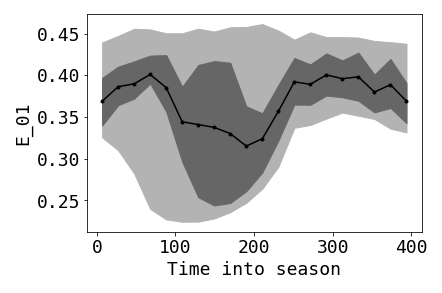

In [19]:
# Plot seasonal statistics of an observable
feat = "t_szn"
obs = "E_01"
sel = dict(ensemble=0, member=0)
fig,ax = helper2.plot_field_1d(
    feat_tpt["ra"]["X"].sel(sel,drop=True).sel(feature=obs).data.flatten(),
    np.ones(feat_tpt["ra"]["t_sim"].size),
    feat_tpt["ra"]["X"].sel(sel).sel(feature=feat).data.flatten(),
    feat_name="Time into season", field_name=obs
)

# Defining A and B
First we make methods for computing the hitting times and destinations (both in forward and backward time) for two sets A and B, as well as their complement D. Each method will have an additional argument, "tpt_bndy", a dictionary of parameters (e.g., thresholds) that specify A and B. This will allow us to consider a whole parameterized family of A and B later on.

First: a function to assign each data point to A, B, or D.

In [309]:
abcode = {"A": 0, "B": 1, "D": 2}
def abtest(Xtpt, tpt_bndy):
    # Given a snapshot of an instance of the feat_tpt data structure, return ab_tag: 
    # 0 means in A, 1 means in B, and 2 means neither.
    # The definition of A and B will be parameterized by a dictionary, tpt_bndy, which specifies
    # the time of season when blockings can happen as well as the thresholds for A and B. 
    time_window_flag = 1.0*(
        Xtpt.sel(feature="t_szn") >= tpt_bndy["tthresh"][0])*(
        Xtpt.sel(feature="t_szn") <= tpt_bndy["tthresh"][1]
    )
    blocked_flag = 1.0*(Xtpt.sel(feature="x1") <= tpt_bndy["x1thresh"][0])
    zonal_flag = 1.0*(Xtpt.sel(feature="x1") >= tpt_bndy["x1thresh"][1])
    ab_tag = (
        abcode["A"]*((1*(time_window_flag == 0) + 1*zonal_flag) > 0) + 
        abcode["B"]*(time_window_flag*blocked_flag) + 
        abcode["D"]*(time_window_flag*(blocked_flag==0)*(zonal_flag==0))
    )
    return ab_tag

Second: compute hitting times. The optimal way to do this depends on whether we have a small number of long trajectories (as in reanalysis), or a large number of short trajectories (as in hindcasts). The functions are named "Cotton Eye Joe", a reference to the American folk song with the famous lyric "where did you come from, where did you go?"

In [310]:
# Function to find the time since and until hitting A and B
def cotton_eye_joe_timesteps(Xtpt, tpt_bndy, ab_tag):
    sintil = xr.DataArray(
        coords = dict({
            "ensemble": Xtpt.coords["ensemble"],
            "member": Xtpt.coords["member"],
            "t_sim": Xtpt.coords["t_sim"],
            "sense": ["since","until"],
            "state": ["A","B"]
        }),
        data = np.nan*np.ones((Xtpt["ensemble"].size, Xtpt["member"].size, Xtpt["t_sim"].size, 2, 2)),
        dims = ["ensemble","member","t_sim","sense","state"],
    )
    # Forward pass through time 
    for i_time in np.arange(sintil["t_sim"].size):    
        if i_time % 200 == 0:
            print(f"Forward pass: through time {i_time} out of {sintil['t_sim'].size}")
        for state in ["A","B"]:            
            if i_time > 0:
                sintil[dict(t_sim=i_time)].loc[dict(sense="since",state=state)] = (
                    sintil.isel(t_sim=i_time-1).sel(sense="since",state=state).data + 
                    sintil["t_sim"][i_time].data - sintil["t_sim"][i_time-1].data
                )
            state_flag = (ab_tag.isel(t_sim=i_time) == abcode[state])
            # Wherever the state is achieved at this time slice, set the time since to zero
            sintil[dict(t_sim=i_time)].loc[dict(sense="since",state=state)] = (
                (xr.zeros_like(sintil.isel(t_sim=i_time).sel(sense="since",state=state))).where(
                state_flag, sintil.isel(t_sim=i_time).sel(sense="since",state=state))
            )
    # Backward pass through time
    for i_time in np.arange(sintil["t_sim"].size-1,-1,-1):
        if i_time % 200 == 0:
            print(f"Backward pass: through time {i_time} out of {sintil['t_sim'].size}")
        for state in ["A","B"]:
            if i_time < sintil["t_sim"].size-1:
                sintil[dict(t_sim=i_time)].loc[dict(sense="until",state=state)] = (
                    sintil.isel(t_sim=i_time+1).sel(sense="until",state=state).data + 
                    sintil["t_sim"][i_time+1].data - sintil["t_sim"][i_time].data
                )
            state_flag = (ab_tag.isel(t_sim=i_time) == abcode[state])
            sintil[dict(t_sim=i_time)].loc[dict(sense="until",state=state)] = (
                (xr.zeros_like(sintil.isel(t_sim=i_time).sel(sense="until",state=state))).where(
                state_flag, sintil.isel(t_sim=i_time).sel(sense="until",state=state))
            )
    return sintil   

In [311]:
# Function to find the time since and until hitting A and B
def cotton_eye_joe_timechunks(Xtpt, tpt_bndy, ab_tag):
    sintil = xr.DataArray(
        coords = dict({
            "ensemble": Xtpt.coords["ensemble"],
            "member": Xtpt.coords["member"],
            "t_sim": Xtpt.coords["t_sim"],
            "sense": ["since","until"],
            "state": ["A","B"]
        }),
        data = np.nan*np.ones((Xtpt["ensemble"].size, Xtpt["member"].size, Xtpt["t_sim"].size, 2, 2)),
        dims = ["ensemble","member","t_sim","sense","state"],
    )
    t_sim = Xtpt["t_sim"].data
    print(f"t_sim.shape = {t_sim.shape}")
    Nt = t_sim.size
    # Forward pass through time 
    for ensemble in Xtpt.coords["ensemble"]:
        for member in Xtpt.coords["member"]:
            for state in ["A","B"]:
                indicator = (ab_tag.sel(ensemble=ensemble,member=member) == abcode[state]).data.astype(int)
                tsince = np.nan*np.ones(Nt)
                tuntil = np.nan*np.ones(Nt)
                # Fill in zeros inside the set
                tsince[indicator==1] = 0.0
                tuntil[indicator==1] = 0.0
                # Find the crossover points
                idx_exit = np.where(np.diff(indicator) == -1)[0] + 1 # First step outside of state
                idx_entry = np.where(np.diff(indicator) == 1)[0] + 1 # First entry to state
                # Take care of boundary cases
                if (not indicator[0]) and len(idx_entry) > 0:
                    tuntil[:idx_entry[0]] = t_sim[idx_entry[0]] - t_sim[:idx_entry[0]]
                    idx_entry = idx_entry[1:]
                if (not indicator[Nt-1]) and len(idx_exit) > 0:
                    tsince[idx_exit[-1]:] = t_sim[idx_exit[-1]:] - t_sim[idx_exit[-1]-1]
                    idx_exit = idx_exit[:-1]
                # Now the middle components: time intervals between exits and entries
                if len(idx_entry) > 0 and len(idx_exit) > 0:
                    for k in range(len(idx_exit)):
                        i0,i1 = idx_exit[k],idx_entry[k]
                        tsince[i0:i1] = t_sim[i0:i1] - t_sim[i0-1]
                        tuntil[i0:i1] = t_sim[i1] - t_sim[i0:i1]
                sintil.loc[dict(ensemble=ensemble,member=member,state=state,sense="since")] = tsince
                sintil.loc[dict(ensemble=ensemble,member=member,state=state,sense="until")] = tuntil
    return sintil   

In [312]:
def cotton_eye_joe(Xtpt, tpt_bndy, ab_tag, mode):
    if mode == "timechunks":
        return cotton_eye_joe_timechunks(Xtpt, tpt_bndy, ab_tag)
    elif mode == "timesteps": 
        return cotton_eye_joe_timesteps(Xtpt, tpt_bndy, ab_tag)
    else:
        raise Exception(f"You asked for a mode of {mode}, but I only accept 'timechunks' or 'timesteps'")

### Set a specific A and B.
The steps below will probably be repeated often with different thresholds. `tthresh` is an array of two time thresholds: the earliest and latest times after the start of the blocking season that a block may occur. `x1thresh` is an array of two thresholds for blocking: the upper limit of B for `x1_runmax`, and the lower limit of A for `x1_runmin`. We will compute the tags for A and B, the hitting times, and the committors, all for reanalysis.

In [319]:
tpt_bndy = {"tthresh": [10,200], "x1thresh": [0.75, 2.0]}
pickle.dump(tpt_bndy, open(join(filedict["results"]["dir"], "tpt_bndy"), "wb"))

In [320]:
for src in ["ra","hc"]:
    ab_tag[src].close()
    sintil[src].close()
    comm[src].close()

In [321]:
if True:
    ab_tag = dict()
    sintil = dict() # Hitting times (since and until)
    comm = dict() # Committor: to B in forward time, from A in backward time
    for src in ["ra","hc"]:
        ab_tag[src] = abtest(feat_tpt[src]["X"], tpt_bndy)
        mode = "timechunks" if src == "ra" else "timesteps"
        sintil[src] = cotton_eye_joe(feat_tpt[src]["X"],tpt_bndy,ab_tag[src],mode=mode)
        comm[src] = 1*(sintil[src].sel(state="B") < sintil[src].sel(state="A"))
        comm[src].loc[dict(sense="since")] = 1 - comm[src].sel(sense="since")
        # Save each item
        ab_tag[src].to_netcdf(join(filedict["results"]["dir"], f"ab_tag_{src}.nc"))    
        sintil[src].to_netcdf(join(filedict["results"]["dir"], f"sintil_{src}.nc"))    
        comm[src].to_netcdf(join(filedict["results"]["dir"], f"comm_{src}.nc"))

t_sim.shape = (160000,)
Forward pass: through time 0 out of 94
Backward pass: through time 0 out of 94


In [322]:
# Reload these
tpt_bndy = pickle.load(open(join(filedict["results"]["dir"], "tpt_bndy"), "rb"))
ab_tag = dict()
sintil = dict() # Hitting times (since and until)
comm = dict() # Committor: to B in forward time, from A in backward time
for src in ["ra","hc"]:
    ab_tag[src] = xr.open_dataarray(join(filedict["results"]["dir"], f"ab_tag_{src}.nc"))    
    sintil[src] = xr.open_dataarray(join(filedict["results"]["dir"], f"sintil_{src}.nc"))    
    comm[src] = xr.open_dataarray(join(filedict["results"]["dir"], f"comm_{src}.nc"))

Plot the A-B tag and hitting times.

Before snips, B: 7 starts, 7 ends
After snips, B: 7 starts, 7 ends


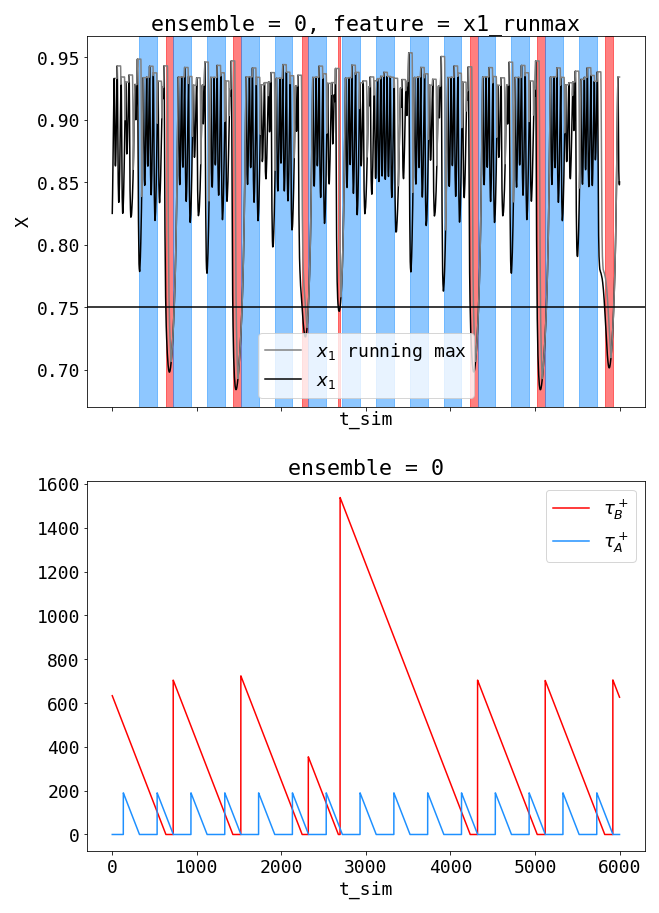

In [323]:
fig,axes = plt.subplots(nrows=2, figsize=(10,15), sharex=True)
sel = dict(member=0, t_sim=slice(None,6000))
h_x1, = xr.plot.plot(
    feat_tpt["ra"]["X"].sel(sel,drop=True).sel(feature="x1"),
    color="black",ax=axes[0],label="$x_1$",x="t_sim"
)
h_x1_runmax, = xr.plot.plot(
    feat_tpt["ra"]["X"].sel(sel,drop=True).sel(feature="x1_runmax"),
    color="gray",ax=axes[0],label="$x_1$ running max",x="t_sim")
# Find all the intervals in B
inb_starts = np.where(np.diff(1*(ab_tag["ra"].sel(sel,drop=True).data.flatten()==abcode["B"])) == 1)[0]
inb_ends = np.where(np.diff(1*(ab_tag["ra"].sel(sel,drop=True).data.flatten()==abcode["B"])) == -1)[0]
print(f"Before snips, B: {len(inb_starts)} starts, {len(inb_ends)} ends")
if inb_starts[0] > inb_ends[0]: 
    inb_starts = inb_starts[1:]
if inb_starts[-1] > inb_ends[-1]:
    inb_starts = inb_starts[:-1]
print(f"After snips, B: {len(inb_starts)} starts, {len(inb_ends)} ends")
for i in range(len(inb_starts)):
    axes[0].axvspan(
        feat_tpt["ra"]["t_sim"][inb_starts[i]], feat_tpt["ra"]["t_sim"][inb_ends[i]], 
        color='red', alpha=0.5, zorder=-1
    )
ina_starts = np.sort(
    np.where(np.diff(1*(ab_tag["ra"].sel(sel,drop=True).data.flatten()==abcode["A"])) == 1)[0])
ina_ends = np.sort(
    np.where(np.diff(1*(ab_tag["ra"].sel(sel,drop=True).data.flatten()==abcode["A"])) == -1)[0])
if ina_starts[0] > ina_ends[0]: 
    ina_ends = ina_ends[1:]
if ina_starts[-1] > ina_ends[-1]:
    ina_starts = ina_starts[:-1]
for i in range(len(ina_starts)):
    axes[0].axvspan(
        feat_tpt["ra"]["t_sim"][ina_starts[i]], feat_tpt["ra"]["t_sim"][ina_ends[i]], 
        color='dodgerblue', alpha=0.5, zorder=-1
    )    

axes[0].axhline(y=tpt_bndy["x1thresh"][0], color='black')
axes[0].legend(handles=[h_x1_runmax,h_x1])
h_tbp, = xr.plot.plot(
    sintil["ra"].sel(sel,drop=True).sel(state="B", sense="until", drop=True),
    ax=axes[1], label="$\\tau_B^+$", color="red")
h_tap, = xr.plot.plot(
    sintil["ra"].sel(sel,drop=True).sel(state="A", sense="until", drop=True),
    ax=axes[1], label="$\\tau_A^+$", color="dodgerblue")
axes[1].legend(handles=[h_tbp,h_tap])

### Find and plot the committor, lead time, and current from reanalysis

In [324]:
# Plot the lead time as a function of E01 and E12
reload(helper2)

<module 'helper2' from '/home/jf4241/ecmwf/tpt_ecmwf/demo/helper2.py'>

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='Ex_11-02', ylabel='Committor to B'>)

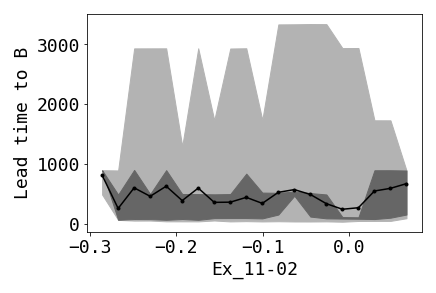

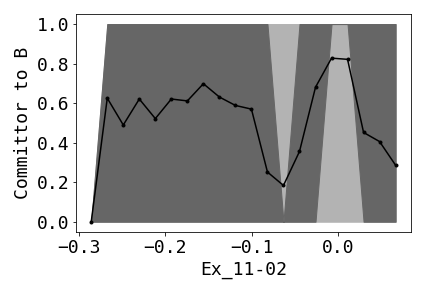

In [325]:
feat = "Ex_11-02"
sel = dict(ensemble=0,member=0)
cond = (
    (feat_tpt["ra"]["X"].sel(sel,drop=True).sel(feature="t_szn") > tpt_bndy["tthresh"][0]) * 
    (feat_tpt["ra"]["X"].sel(sel,drop=True).sel(feature="t_szn") < tpt_bndy["tthresh"][0]+10) 
)
helper2.plot_field_1d(
    sintil["ra"].sel(sel,drop=True).sel(sense="until",state="B").where(cond).data.flatten(), 
    np.ones(cond["t_sim"].size),
    feat_tpt["ra"]["X"].sel(sel).sel(feature=[feat]).where(cond).data.flatten(),
    ax=axes[0],
    feat_name=feat, field_name="Lead time to B",
)
helper2.plot_field_1d(
    comm["ra"].sel(sel,drop=True).sel(sense="until").where(cond).data.flatten(), 
    np.ones(cond["t_sim"].size),
    feat_tpt["ra"]["X"].sel(sel).sel(feature=feat).where(cond).data.flatten(),
    ax=axes[1],
    feat_name=feat, field_name="Committor to B"
)

Choose two features for the space to plot

In [326]:
# Plot the lead time as a function of E01 and E12
reload(helper2)

<module 'helper2' from '/home/jf4241/ecmwf/tpt_ecmwf/demo/helper2.py'>

(<Figure size 1080x360 with 3 Axes>,
 <AxesSubplot:title={'center':'$-\\tau_B^+$'}, xlabel='Ex_11-diss', ylabel='Ex_11-12'>)

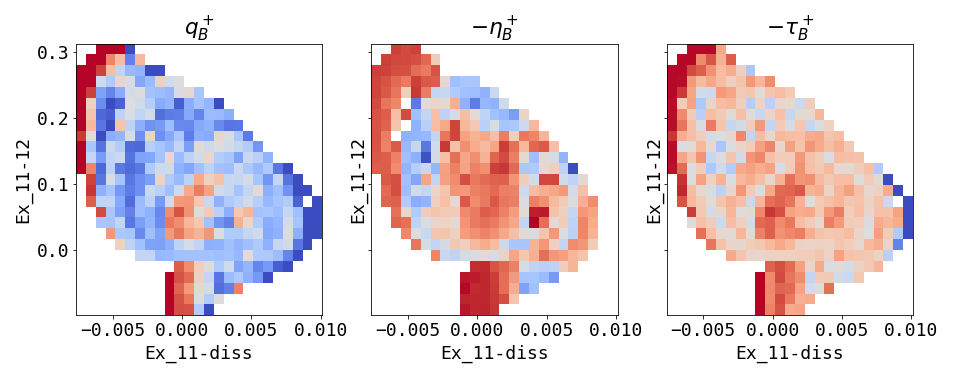

In [327]:
feat0,feat1 = "Ex_11-diss","Ex_11-12"
sel = dict(ensemble=0,member=0) 
cond = (
    (feat_tpt["ra"]["X"].sel(sel,drop=True).sel(feature="t_szn") > tpt_bndy["tthresh"][0]) * 
    (feat_tpt["ra"]["X"].sel(sel,drop=True).sel(feature="t_szn") < tpt_bndy["tthresh"][1]) 
)
qp = comm["ra"].sel(sel,drop=True).sel(sense="until").where(cond).data.flatten()
Tb = sintil["ra"].sel(sel,drop=True).sel(sense="until",state="B").where(cond).data.flatten()

fig,axes = plt.subplots(ncols=3,figsize=(15,5), sharey=True, sharex=True)
helper2.plot_field_2d(
    qp,
    np.ones(feat_tpt["ra"]["t_sim"].size),
    feat_tpt["ra"]["X"].sel(feature=[feat0,feat1]).where(cond).sel(sel,drop=True),
    feat_names = [feat0,feat1], 
    shp=[25,25], fig=fig, ax=axes[0], field_name=r"$q_B^+$"
)
helper2.plot_field_2d(
    -Tb*qp ,
    qp,
    feat_tpt["ra"]["X"].sel(feature=[feat0,feat1]).where(cond).sel(sel,drop=True),
    feat_names = [feat0,feat1], 
    shp=[25,25], fig=fig, ax=axes[1], field_name=r"$-\eta_B^+$"
)
helper2.plot_field_2d(
    -Tb,
    np.ones(feat_tpt["ra"]["t_sim"].size),
    feat_tpt["ra"]["X"].sel(feature=[feat0,feat1]).where(cond).sel(sel,drop=True),
    feat_names = [feat0,feat1], 
    shp=[25,25], fig=fig, ax=axes[2], field_name=r"$-\tau_B^+$"
)

# Markov State Modeling using hindcasts

The steps to building a MSM:
1. Select a set of features
2. Cluster the data *separately at each time of the season*
3. Count transitions from each box to each other box
4. Build a list of matrices

In [328]:
reload(helper2)

<module 'helper2' from '/home/jf4241/ecmwf/tpt_ecmwf/demo/helper2.py'>

In [329]:
msm_features = ["x1","x2","x3","x4","x5","x6"]
feat_msm = dict()
for src in ["ra","hc"]:
    feat_msm[src] = feat_tpt[src]["X"].sel(feature=msm_features)

We want a homogeneously shaped dataset for clustering. Therefore we need to de-mean and normalize each feature. Compute the mean and standard deviation (from reanalysis) for each time window throughout the season.

In [330]:
# Compute seasonal statistics
szn_stats_dict,edges,centers = helper2.project_field(
    feat_msm["ra"].sel(ensemble=0,member=0).data, 
    np.ones_like(feat_msm["ra"].sel(ensemble=0,member=0).data),
    feat_tpt["ra"]["X"].sel(feature="t_szn",ensemble=0,member=0).data.reshape(-1,1),
    bounds = np.array([0.0, crom_feat.year_length+0.0001]).reshape(-1,1),
    shp = (int(crom_feat.year_length/crom_feat.dt_szn + 0.5),)
)
szn_stats = xr.Dataset(
    data_vars = dict({
        key: xr.DataArray(
            coords={"t_szn_cent": centers[0], "feature": msm_features,},
            data=szn_stats_dict[key],
            dims=["t_szn_cent", "feature"],
        ) 
        for key in list(szn_stats_dict.keys())
    }),
    attrs = {
        "t_szn_edge": edges[0], "t_szn_cent": centers[0], 
        "dt_szn": edges[0][1]-edges[0][0], "Nt_szn": len(centers[0]),
        "szn_start": epd["szn_start"], "szn_length": epd["szn_length"]
    }
)

In [331]:
feat_msm_normalized = dict()
szn_window = dict()
szn_start_year = dict()
traj_beginning_flag = dict() # 1 if the sample is in the first seasonal time window where the trajectory started
traj_ending_flag = dict() # 1 if the sample is in the last seasonal time window occupied by the trajectory
for src in ["ra","hc"]:
    feat_msm_normalized[src] = feat_msm[src].copy(deep=True)
    szn_window[src] = (feat_tpt[src]["X"].sel(feature="t_szn")/szn_stats.attrs["dt_szn"]).astype(int)
    szn_start_year[src] = feat_tpt[src]["X"].sel(feature="szn_start_year").astype(int)
    for i_win in range(szn_stats.attrs["Nt_szn"]):
        feat_msm_normalized[src] = xr.where(
            szn_window[src]==i_win, 
            (feat_msm_normalized[src] - szn_stats["mean"].isel(t_szn_cent=i_win,drop=True)) / szn_stats["std"].isel(t_szn_cent=i_win,drop=True), 
            feat_msm_normalized[src]
        )
    # --------------- Mark the trajectories that originated in an earlier time window and will reach another time window ---------------
    # TODO: correct these definitions for multi-year trajectories that end in the same place as they started
    traj_ending_flag[src] = (
        (szn_window[src] == szn_window[src].isel(t_sim=-1,drop=True))*
        (szn_start_year[src] == szn_start_year[src].isel(t_sim=-1,drop=True))
    )
    traj_beginning_flag[src] = (
        (szn_window[src] == szn_window[src].isel(t_sim=0,drop=True))*
        (szn_start_year[src] == szn_start_year[src].isel(t_sim=0,drop=True))
    )
    # -----------------------------------------------------------------------------------------------

Now let's cluster into boxes at each timestep. Note, this could be parallelized. We will choose a subset of all the samples to find the clusters, and only those trajectories that neither start nor end in that time window. This way, we ensure no transition matrix rows are empty. 

In [332]:
km_seed = 43

km_assignment = dict()
km_centers = dict()
km_n_clusters = dict()
for src in ["hc","ra"]:
    km_assignment_src = -np.ones((feat_tpt[src]["ensemble"].size,feat_tpt[src]["member"].size,feat_tpt[src]["t_sim"].size), dtype=int)
    km_centers[src] = []
    km_n_clusters[src] = -np.ones(szn_stats.attrs["Nt_szn"], dtype=int)

    for i_win in range(szn_stats.attrs["Nt_szn"]):
        if i_win % 10 == 0:
            print(f"Starting K-means number {i_win} out of {szn_stats.attrs['Nt_szn']}")
        idx_in_window = np.where(szn_window[src].data==i_win) # All the data in this time window
        # idx_for_clustering is all the data that we're allowed to use to build the KMeans object
        if i_win == 0:
            idx_for_clustering = np.where(
                (szn_window[src].data==i_win)*
                (traj_ending_flag[src].data == 0)
            )
        elif i_win == szn_stats.attrs["Nt_szn"]-1:
            idx_for_clustering = np.where(
                (szn_window[src].data==i_win)*
                (traj_beginning_flag[src].data == 0)
            )            
        else:
            idx_for_clustering = np.where(
                (szn_window[src].data==i_win)*
                (traj_ending_flag[src].data == 0)*
                (traj_beginning_flag[src].data == 0)
            )
        km_n_clusters[src][i_win] = min(200,max(1,len(idx_for_clustering[0]//2)))
        km = KMeans(n_clusters=km_n_clusters[src][i_win],random_state=km_seed).fit(
                feat_msm_normalized[src].data[idx_for_clustering])
        km_assignment_src[idx_in_window] = km.predict(feat_msm_normalized[src].data[idx_in_window]) 
        km_centers[src] += [km.cluster_centers_]
        #print(f"\tkm_centers computation: {t5 - t4}")
    km_assignment[src] = xr.DataArray(
        coords={"ensemble": feat_tpt[src]["ensemble"], "member": feat_tpt[src]["member"], "t_sim": feat_tpt[src]["t_sim"]},
        dims=["ensemble","member","t_sim"],
        data=km_assignment_src.copy()    #np.zeros((feat_tpt[src]["ensemble"].size,feat_tpt[src]["member"].size,feat_tpt[src]["t_sim"].size), dtype=int)
    )    



Starting K-means number 0 out of 80
Starting K-means number 10 out of 80
Starting K-means number 20 out of 80
Starting K-means number 30 out of 80
Starting K-means number 40 out of 80
Starting K-means number 50 out of 80
Starting K-means number 60 out of 80
Starting K-means number 70 out of 80
Starting K-means number 0 out of 80
Starting K-means number 10 out of 80
Starting K-means number 20 out of 80
Starting K-means number 30 out of 80
Starting K-means number 40 out of 80
Starting K-means number 50 out of 80
Starting K-means number 60 out of 80
Starting K-means number 70 out of 80


Now build the Markov State Model by counting transitions from box to box. This part could also be parallelized.

In [ ]:
P_list = dict()
for src in ["hc","ra"]:
    time_dim = list(szn_window[src].dims).index("t_sim")
    nontime_dims = np.setdiff1d(np.arange(len(szn_window[src].dims)), [time_dim])
    P_list[src] = []
    for i_win in range(szn_stats.attrs["Nt_szn"]-1):
        if i_win % 10 == 0: print(f"i_win = {i_win}")
        P = np.zeros((km_n_clusters[src][i_win],km_n_clusters[src][i_win+1]))
        # Count the trajectories that passed through both box i during window i_win, and box j during window i_win+1. 
        # Maybe some trajectories will be double counted. 
        idx_pre = np.where(szn_window[src].data==i_win)
        idx_post = np.where(szn_window[src].data==i_win+1)
        overlap = np.where(
            np.all(
                np.array([
                    (np.subtract.outer(idx_pre[dim], idx_post[dim]) == 0) 
                    for dim in nontime_dims
                ]), axis=0
            ) * (
                np.subtract.outer(
                    szn_start_year[src].data[idx_pre], szn_start_year[src].data[idx_post]
                ) == 0
            )          
        )
        idx_pre_overlap = tuple([idx_pre[dim][overlap[0]] for dim in range(len(idx_pre))])
        idx_post_overlap = tuple([idx_post[dim][overlap[1]] for dim in range(len(idx_pre))])
        km_pre = km_assignment[src].data[idx_pre_overlap]
        km_post = km_assignment[src].data[idx_post_overlap]
        ensemble_member_year_identifier = np.concatenate((
            np.array(idx_pre_overlap)[nontime_dims,:], 
            [szn_start_year[src].data[idx_pre_overlap]]
        ), axis=0)
        for i in range(P.shape[0]):
            for j in range(P.shape[1]):
                traj_idx, = np.where((km_pre==i)*(km_post==j))
                P[i,j] = np.unique(ensemble_member_year_identifier[:,traj_idx], axis=1).shape[1]
        min_rowsum = np.min(np.sum(P, axis=1))
        min_colsum = np.min(np.sum(P, axis=0))
        if min_rowsum == 0 or min_colsum == 0:
            raise Exception(f"Under-filled transition matrices between seasonal windows {i_win} and {i_win+1}. min_rowsum = {min_rowsum} and min_colsum = {min_colsum}")
        P_list[src] += [P]


i_win = 0
i_win = 10
i_win = 20
i_win = 30
i_win = 40
i_win = 50
i_win = 60
i_win = 70


In [262]:
# Normalize each matrix
for src in ["hc","ra"]:
    for i_win in range(szn_stats.attrs["Nt_szn"]-1):
        P_list[src][i_win] = (
            np.diag(1.0/np.sum(P_list[src][i_win], axis=1))
            .dot(P_list[src][i_win])
        )

In [263]:
# Save out the data relevant for clustering
msm_info = dict()
for src in ["hc","ra"]:
    msm_info[src] = dict({
        "szn_window": szn_window[src],
        "szn_start_year": szn_start_year[src],
        "traj_beginning_flag": traj_beginning_flag[src],
        "traj_ending_flag": traj_ending_flag[src],
        "km_centers": km_centers[src],
        "km_assignment": km_assignment[src],
        "km_n_clusters": km_n_clusters[src],
        "P_list": P_list[src],
    })
pickle.dump(msm_info, open(join(filedict["results"]["dir"], "msm_info"), "wb"))

In [264]:
msm_info = pickle.load(open(join(filedict["results"]["dir"], "msm_info"), "rb"))

In [265]:
# Make a function to assign every point in the dataset a value according to its K-means assignment
def broadcast_field_msm2dataarray(msm, field_msm, szn_stats, density_flag=False):
    field_da = np.zeros(msm["szn_window"].shape)
    for i_win in range(szn_stats.attrs["Nt_szn"]):
        idx_in_window = np.where(msm["szn_window"].data == i_win)
        for i_clust in range(msm["km_n_clusters"][i_win]):
            idx_in_cluster = np.where(msm["km_assignment"].data[idx_in_window] == i_clust)
            idx_in_window_and_cluster = tuple([idx_in_window[dim][idx_in_cluster] for dim in range(len(idx_in_window))])
            field_da[idx_in_window_and_cluster] = field_msm[i_win][i_clust]
            if density_flag and (len(idx_in_window_and_cluster[0]) > 0):
                field_da[idx_in_window_and_cluster] *= 1.0/len(idx_in_window_and_cluster[0])
    da_broadcast = xr.DataArray(
        coords = msm["szn_window"].coords,
        dims = msm["szn_window"].dims, 
        data = field_da,
    )
    return da_broadcast


# Solve for the committor

First assign flags to each cluster center for A or B membership. For this we need to refer to the original data in the membership list of each cluster.

In [303]:
# Create a list of vectors to flag whether each cluster at each time is in A or is in B
src = "hc"
ina = []
inb = []
for i_win in range(szn_stats.attrs["Nt_szn"]):
    ina += [np.zeros(km_n_clusters[src][i_win], dtype=float)]    
    inb += [np.zeros(km_n_clusters[src][i_win], dtype=float)]
    idx_in_window = np.where(szn_window[src].data==i_win)
    ab_tag_in_window = ab_tag[src].data[idx_in_window]
    for i_clust in range(km_n_clusters[src][i_win]):
        idx_in_cluster = np.where(km_assignment[src].data[idx_in_window]==i_clust)
        ina[i_win][i_clust] = np.mean(1.0*ab_tag_in_window[idx_in_cluster]==abcode["A"])
        inb[i_win][i_clust] = np.mean(1.0*ab_tag_in_window[idx_in_cluster]==abcode["B"])

In [304]:
sum(np.concatenate(inb))

32.48730792831485

In [305]:
# Instantiate the time-dependent Markov Chain class
import tdmc_obj
mc = tdmc_obj.TimeDependentMarkovChain(msm_info[src]["P_list"], szn_stats.attrs["t_szn_cent"])

# Solve for the committor
G = [] 
F = [] 
for i in range(mc.Nt):
    G += [1.0*inb[i]]
    if i < mc.Nt-1: F += [1.0*np.outer((ina[i]==0)*(inb[i]==0), np.ones(mc.Nx[i+1]))]
qp = mc.dynamical_galerkin_approximation(F,G)

# Solve for the time-dependent density
init_dens = np.ones(msm_info["hc"]["km_n_clusters"][0]) 
init_dens *= 1.0/np.sum(init_dens)
dens = mc.propagate_density_forward(init_dens)

# Solve for the backward committor
P_list_bwd = []                                                        
for i in np.arange(mc.Nt-2,-1,-1):
    P_list_bwd += [(msm_info["hc"]["P_list"][i] * np.outer(dens[i], 1.0/dens[i+1])).T]        
    rowsums = np.sum(P_list_bwd[-1],axis=1)                    
G = []
F = []
for i in np.arange(mc.Nt-1,-1,-1):                             
    G += [1.0*ina[i]]                                          
    if i < mc.Nt-1: 
        Fnew = np.outer(1.0*(ina[i+1]==0)*(inb[i+1]==0), np.ones(len(inb[i]))) 
        F += [Fnew.copy()]
qm = mc.dynamical_galerkin_approximation(F,G)                  
qm.reverse()

# Solve for the rate
flux = []
rate_froma = 0
rate_tob = 0
flux_froma = []
flux_tob = []
flux_dens_tob = np.zeros(szn_stats.attrs["Nt_szn"])
for ti in range(szn_stats.attrs["Nt_szn"]-1):
    flux += [(msm_info["hc"]["P_list"][ti].T * dens[ti] * qm[ti]).T * qp[ti+1]]
    flux_froma += [(msm_info["hc"]["P_list"][ti].T * dens[ti] * ina[ti]).T * qp[ti+1]]
    flux_tob += [(msm_info["hc"]["P_list"][ti].T * dens[ti] * qm[ti]).T * inb[ti+1]]
    rate_froma += np.sum(flux_froma[-1])
    rate_tob += np.sum(flux_tob[-1])
    flux_dens_tob[ti] = np.sum(flux_tob[-1])

In [307]:
rate_froma

0.10081328420230418

In [274]:
qp_da = broadcast_field_msm2dataarray(msm_info[src], qp, szn_stats)
pi_da = broadcast_field_msm2dataarray(msm_info[src], dens, szn_stats, density_flag=True)
qm_da = broadcast_field_msm2dataarray(msm_info[src], qm, szn_stats)

(<Figure size 1080x360 with 3 Axes>,
 <AxesSubplot:title={'center':'$q_A^-$'}, xlabel='t_szn', ylabel='x1'>)

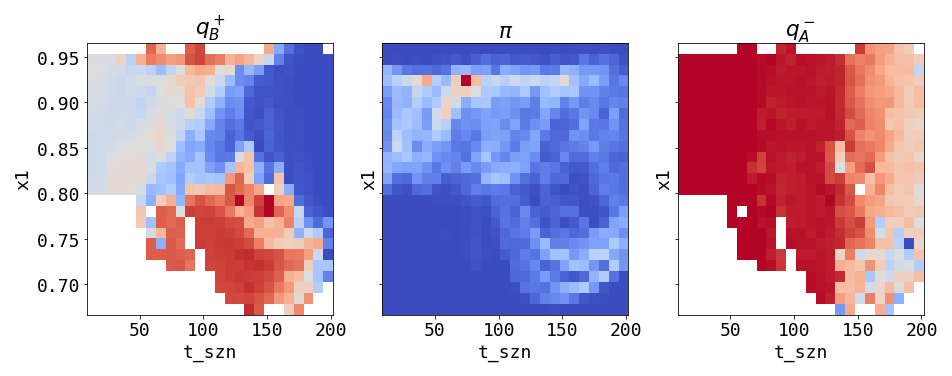

In [275]:
fig,axes = plt.subplots(ncols=3,figsize=(15,5),sharey=True)
cond = (
    (feat_tpt["hc"]["X"].sel(feature="t_szn",drop=True) > tpt_bndy["tthresh"][0]) * 
    (feat_tpt["hc"]["X"].sel(feature="t_szn",drop=True) < tpt_bndy["tthresh"][1]) 
)
feat0,feat1 = "t_szn","x1"
features = np.array([feat_tpt["hc"]["X"].sel(feature=ft).where(cond).data.flatten() for ft in [feat0,feat1]]).T
weights = np.ones(features.shape[0])
helper2.plot_field_2d(
    qp_da.where(cond).data.flatten(),
    weights,
    features,
    feat_names = [feat0,feat1], 
    shp=[25,25], fig=fig, ax=axes[0], field_name=r"$q_B^+$"
)
helper2.plot_field_2d(
    pi_da.where(cond).data.flatten(),
    weights,
    features,
    feat_names = [feat0,feat1], 
    shp=[25,25], fig=fig, ax=axes[1], field_name=r"$\pi$",
    stat_name="sum"
)
helper2.plot_field_2d(
    qm_da.where(cond).data.flatten(),
    weights,
    features,
    feat_names = [feat0,feat1], 
    shp=[25,25], fig=fig, ax=axes[2], field_name=r"$q_A^-$"
)

In [111]:
field

(array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan]),)

In [106]:
np.mean(qp_da.data.flatten() > 0)

0.3184862812522387